<a href="https://colab.research.google.com/github/kangggchan/SeamCarvingExperiment/blob/main/SeamCarving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving 000040.JPG to 000040.JPG


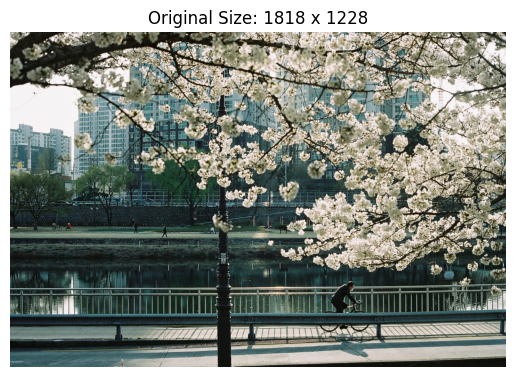

In [3]:
filename = next(iter(uploaded))
image = cv2.imread(filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(f'Original Size: {image.shape[1]} x {image.shape[0]}')
plt.axis('off')
plt.show()


In [4]:
height, width = image.shape[:2]
image = cv2.resize(image, (width // 2, height // 2), interpolation=cv2.INTER_LINEAR)

In [5]:
def energy_map(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    dx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    energy = np.abs(dx) + np.abs(dy)
    return energy

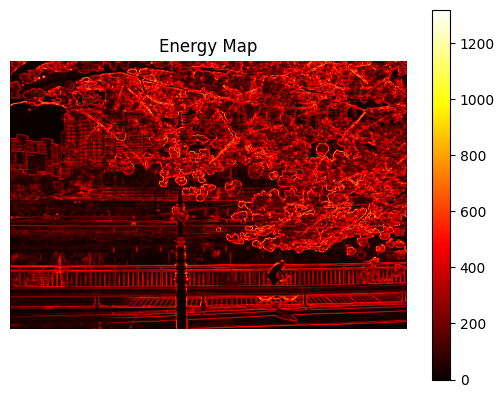

In [6]:
energy = energy_map(image)
plt.imshow(energy, cmap='hot')
plt.colorbar()
plt.title('Energy Map')
plt.axis('off')
plt.show()

In [7]:
def minimum_seam(energy):
    rows, cols = energy.shape
    seam = np.zeros(rows, dtype=np.uint32)
    dp = energy.copy()

    for i in range(1, rows):
        for j in range(cols):
            min_energy = dp[i-1, j]
            if j > 0:
                min_energy = min(min_energy, dp[i-1, j-1])
            if j < cols - 1:
                min_energy = min(min_energy, dp[i-1, j+1])
            dp[i, j] += min_energy

    seam[rows - 1] = np.argmin(dp[-1])
    for i in range(rows - 2, -1, -1):
        j = seam[i + 1]
        if j > 0 and dp[i, j - 1] == dp[i+1, j] - energy[i+1, j]:
            j -= 1
        elif j < cols - 1 and dp[i, j + 1] == dp[i+1, j] - energy[i+1, j]:
            j += 1
        seam[i] = j

    return seam, dp


In [8]:
def highlight_seam(img, seam, thickness):
    img_with_seam = img.copy()
    rows, cols, _ = img.shape

    for i in range(len(seam)):
        col = seam[i]
        # Color the seam pixel and surrounding pixels based on the specified thickness
        for t in range(-thickness // 2, thickness // 2 + 1):
            if 0 <= col + t < cols:  # Ensure we stay within image bounds
                img_with_seam[i, col + t] = [255, 0, 0]  # Set seam and neighbors to red

    return img_with_seam


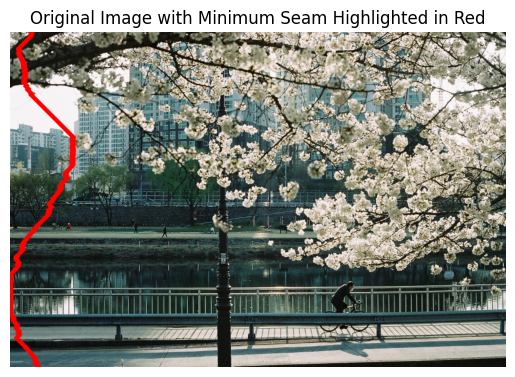

In [9]:
energy = energy_map(image)

seam, _ = minimum_seam(energy)

img_with_seam = highlight_seam(image, seam, 10)

plt.imshow(img_with_seam)
plt.axis('off')
plt.title("Original Image with Minimum Seam Highlighted in Red")
plt.show()


In [11]:
image.shape[0]


614

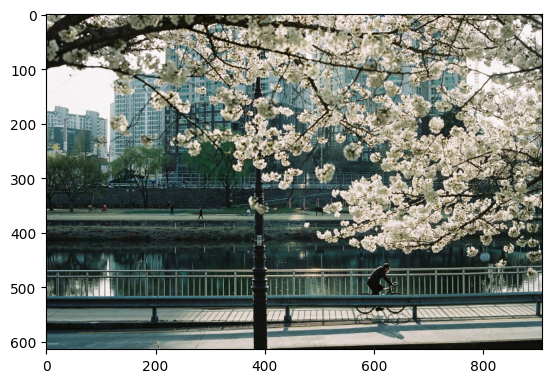

In [12]:
plt.imshow(image)


In [13]:
def remove_seam(img, seam):
    rows, cols, _ = img.shape
    new_img = np.zeros((rows, cols - 1, 3), dtype=img.dtype)
    for i in range(rows):
        j = seam[i]
        new_img[i, :, :] = np.delete(img[i, :, :], j, axis=0)
    return new_img

In [14]:
def seam_carve(img, target_width, target_height):
    img_resized = img.copy()
    current_height, current_width = img.shape[:2]

    # Horizontal resizing (width)
    while current_width > target_width:
        energy = energy_map(img_resized)
        seam, _ = minimum_seam(energy)
        img_resized = remove_seam(img_resized, seam)
        current_width -= 1  # Update current width

    # Rotate the image for vertical seam removal (height)
    img_resized = np.rot90(img_resized, 1, (0, 1))
    current_height = img_resized.shape[1]  # New height after rotation

    # Vertical resizing (height)
    while current_height > target_height:
        energy = energy_map(img_resized)
        seam, _ = minimum_seam(energy)
        img_resized = remove_seam(img_resized, seam)
        current_height -= 1  # Update current height

    # Rotate back to original orientation
    img_resized = np.rot90(img_resized, 3, (0, 1))

    return img_resized


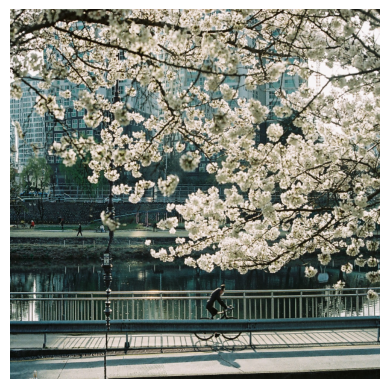

In [15]:
new_width = 614
new_height = 614
resized_image = seam_carve(image, new_width, new_height)

plt.imshow(resized_image)
plt.axis('off')
plt.show()